In [1]:
import sys, os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.nn import *

In [2]:
transform = transforms.Compose([
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.RandomPerspective(),
    transforms.ToTensor(),
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../../data',
    train=True,
    transform=transform,
    # transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

print(type(train_dataset.data), train_dataset.data.shape)
print(type(train_dataset.targets), len(train_dataset.targets))

Files already downloaded and verified
Files already downloaded and verified
<class 'numpy.ndarray'> (50000, 32, 32, 3)
<class 'list'> 50000


In [4]:
K = len(set(train_dataset.targets))
print("Number of classes:", K)

Number of classes: 10


In [5]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)

        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN(K)
model.to(device)

print(device)

cuda:0


In [8]:
critrion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses, test_losses = batch_gd(
    model, critrion, optimizer, train_loader, test_loader, 80, device
)

Epoch 1/80, Train Loss: 1.4353, Test Loss: 1.0754, Duration: 0:00:31.338917
Epoch 2/80, Train Loss: 0.9970, Test Loss: 0.9962, Duration: 0:00:31.029210
Epoch 3/80, Train Loss: 0.8345, Test Loss: 0.8169, Duration: 0:00:30.590087
Epoch 4/80, Train Loss: 0.7511, Test Loss: 0.7818, Duration: 0:00:31.152068
Epoch 5/80, Train Loss: 0.6904, Test Loss: 0.6554, Duration: 0:00:32.114030
Epoch 6/80, Train Loss: 0.6456, Test Loss: 0.6159, Duration: 0:00:33.335106
Epoch 7/80, Train Loss: 0.6128, Test Loss: 0.6153, Duration: 0:00:33.777127
Epoch 8/80, Train Loss: 0.5793, Test Loss: 0.5941, Duration: 0:00:34.887144
Epoch 9/80, Train Loss: 0.5511, Test Loss: 0.5969, Duration: 0:00:34.277696
Epoch 10/80, Train Loss: 0.5281, Test Loss: 0.5650, Duration: 0:00:34.178924
Epoch 11/80, Train Loss: 0.5096, Test Loss: 0.5547, Duration: 0:00:34.854423
Epoch 12/80, Train Loss: 0.4846, Test Loss: 0.5148, Duration: 0:00:34.444605
Epoch 13/80, Train Loss: 0.4813, Test Loss: 0.5603, Duration: 0:00:34.294382
Epoch 14

Train accuracy: tensor(0.9435, device='cuda:0')
Test accuracy: tensor(0.8911, device='cuda:0')


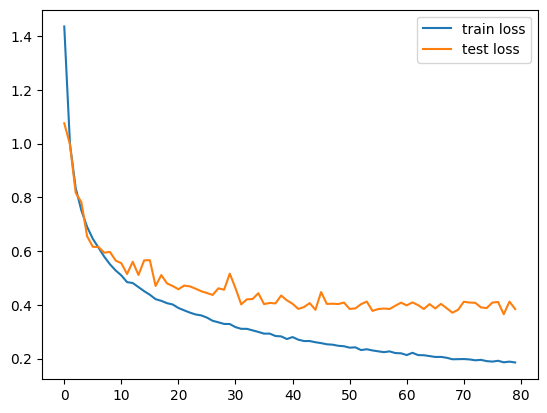

In [10]:
print("Train accuracy:", compute_accuracy(model, train_loader, device))
print("Test accuracy:", compute_accuracy(model, test_loader, device))

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

[[880   6  25  12  10   3   6   6  35  17]
 [  8 934   0   5   0   0   2   1   6  44]
 [ 40   0 818  32  36  18  39  15   2   0]
 [ 19   4  26 810  34  59  20  21   3   4]
 [  6   0  29  30 882  14  20  17   2   0]
 [  7   0  20 126  32 771  13  30   0   1]
 [  8   0  17  34  13   2 920   4   1   1]
 [  6   0   9  20  26  20   4 910   1   4]
 [ 41   6   5   5   6   1   2   0 927   7]
 [ 15  30   0   5   2   1   3   6  14 924]]
Confusion matrix, without normalization


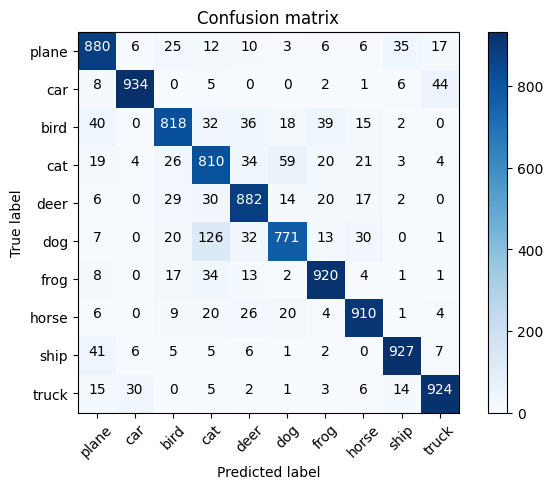

In [12]:
# get all predictions in an array and plot confusion matrix
confusion_matrix = get_confusion_matrix(test_loader, model, device)
print(confusion_matrix)

plot_confusion_matrix(confusion_matrix, [
    "plane", "car", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

In [13]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6